# Brain Tumor Detection with image processing and CNN

In [1]:
#import 
import cv2
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 
import keras
import numpy as np
# !pip install imutils
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

# dataset path 
path = "D:/Image_datasets/brain_tumor_dataset"
# make sure in this dir two folder named "yes" and "no" is present. 

In [2]:
def crop_contour_brain_img(image, plot=False):
    grayscale=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale=cv2.GaussianBlur(grayscale,(5,5),0)
    threshhold_image=cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshhold_image=cv2.erode(threshhold_image,None,iterations=2)
    threshhold_image=cv2.dilate(threshhold_image,None,iterations=2)
    
    countour=cv2.findContours(threshhold_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    countour=imutils.grab_contours(countour)
    c=max(countour, key=cv2.contourArea)
    
    extreme_pnts_left=tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right=tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top=tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot=tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1],extreme_pnts_left[0]:extreme_pnts_right[0]]
    new_image= cv2.threshold(new_image, 100, 255, cv2.THRESH_BINARY,cv2.CHAIN_APPROX_SIMPLE)[1]
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("original image")
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("processed image")
        plt.show()
        
    return new_image

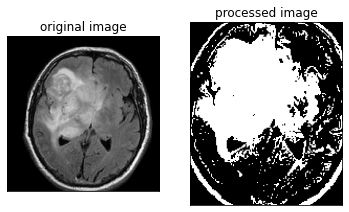

In [4]:
example_image=cv2.imread(path+"/yes/Y2.jpg")
img=crop_contour_brain_img(example_image,True)
# plt.imshow(img)
print()

In [160]:
def load_images(path,type="jpg",target=0,images=[],result=[]):
    for filepath in os.listdir(path):
        if filepath.split(".")[-1].lower()=="jpg" or filepath.split(".")[-1].lower()=="jpeg":
            img=cv2.imread(path+"/"+filepath)
            img=crop_contour_brain_img(img)
            img=cv2.resize(img,(128,128))
            
            img=np.array(img)
            images.append(img)
            result.append(encoder.transform([[target]]).toarray())
    
    return [images,result]

def show_image(datasets,num=4):  
    for i in range(num**2):
        plt.subplot(num, num, i+1)
        plt.imshow(datasets[i])
        plt.axis('off')


In [161]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

OneHotEncoder()

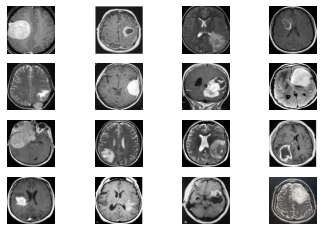

In [162]:
images,result=load_images(path+"/yes",target=0,images=[],result=[])
# print(images.shape)
show_image(images)
# print(result)


total images : 245 | total targets : 245


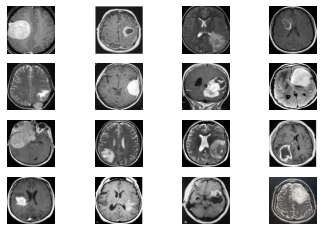

In [163]:
images,result=load_images(path+"/no",target=1,images=images,result=result)
# print(no_images.shape)
show_image(images)
print("total images :",len(result),"| total targets :",len(images))

In [164]:
data=np.array(images)
print(data.shape)

(245, 128, 128, 3)


In [168]:
target=np.array(result)
target=target.reshape(245,2)
print(target.shape)
# print(target)

(245, 2)


In [171]:
x_train,x_test,y_train,y_test=train_test_split(data, target, test_size=0.2, shuffle=True, random_state=0)

In [173]:
x_train.shape,y_test.shape

((196, 128, 128, 3), (49, 2))

In [179]:
def get_model():
    model = keras.Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
    model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
    
    return model
model=get_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1

In [180]:
cnn = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
5/5 [==============================] - 8s 1s/step - loss: 45.9519 - val_loss: 65.8297
Epoch 2/30
5/5 [==============================] - 6s 1s/step - loss: 12.7418 - val_loss: 18.9396
Epoch 3/30
5/5 [==============================] - 6s 1s/step - loss: 3.9306 - val_loss: 36.9124
Epoch 4/30
5/5 [==============================] - 6s 1s/step - loss: 5.0709 - val_loss: 8.6711
Epoch 5/30
5/5 [==============================] - 6s 1s/step - loss: 2.4054 - val_loss: 23.2634
Epoch 6/30
5/5 [==============================] - 6s 1s/step - loss: 2.0002 - val_loss: 14.6508
Epoch 7/30
5/5 [==============================] - 6s 1s/step - loss: 1.1639 - val_loss: 3.3531
Epoch 8/30
5/5 [==============================] - 6s 1s/step - loss: 0.6523 - val_loss: 2.7489
Epoch 9/30
5/5 [==============================] - 6s 1s/step - loss: 0.4814 - val_loss: 3.4043
Epoch 10/30
5/5 [==============================] - 6s 1s/step - loss: 0.3305 - val_loss: 8.8114
Epoch 11/30
5/5 [=========================

In [228]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 118ms/step - loss: 1.2016


1.2016478776931763

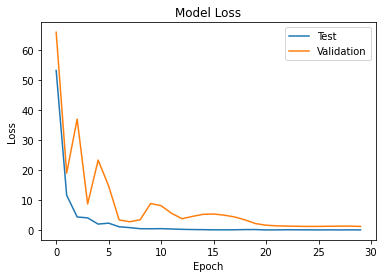

In [223]:
# plotting loss
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [296]:
def analysis_pred(pred,org,tags=[1,0]):
    accurate=0
    for i in range(len(pred)):
        print(i,")  predicted :",tags[np.array(pred[i]).argmax()],end=" | ")
        print("Original :",tags[np.array(org[i]).argmax()], end=" | ")
        if np.array(pred[i]).argmax()==np.array(org[i]).argmax():
            print("accurate : Yes.")
            accurate+=1
        else:
            print("accurate : No.")
    print("\n"+("-")*10+"score"+("-")*10)
    print("accurate=",accurate,"/",len(pred)," | accuracy=",round((accurate/len(pred)*100),3),"%")
        

In [297]:
res = model.predict_on_batch(x_test)

# index 0 : no tumor
# index 1 : tumor
analysis_pred(res,y_test,["tumor","No tumor"])


0 )  predicted : No tumor | Original : tumor | accurate : No.
1 )  predicted : No tumor | Original : No tumor | accurate : Yes.
2 )  predicted : No tumor | Original : tumor | accurate : No.
3 )  predicted : No tumor | Original : tumor | accurate : No.
4 )  predicted : No tumor | Original : No tumor | accurate : Yes.
5 )  predicted : No tumor | Original : No tumor | accurate : Yes.
6 )  predicted : tumor | Original : tumor | accurate : Yes.
7 )  predicted : tumor | Original : tumor | accurate : Yes.
8 )  predicted : tumor | Original : tumor | accurate : Yes.
9 )  predicted : No tumor | Original : tumor | accurate : No.
10 )  predicted : No tumor | Original : No tumor | accurate : Yes.
11 )  predicted : No tumor | Original : tumor | accurate : No.
12 )  predicted : tumor | Original : tumor | accurate : Yes.
13 )  predicted : No tumor | Original : No tumor | accurate : Yes.
14 )  predicted : No tumor | Original : No tumor | accurate : Yes.
15 )  predicted : tumor | Original : tumor | accu

Text(69.0, 0.5, 'Truth')

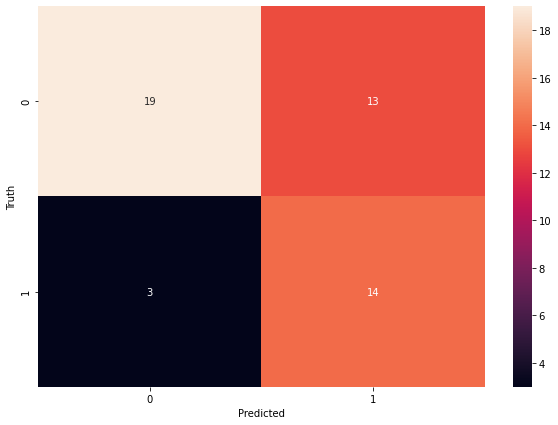

In [233]:
y_pred=model.predict(x_test)
y_pred_labels=[np.argmax(i) for i in y_pred]
y_test_labels=[np.argmax(i) for i in y_test]
cm=tf.math.confusion_matrix(labels=y_test_labels,predictions=y_pred_labels)

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [234]:
print(classification_report(y_test_labels,y_pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.59      0.70        32
           1       0.52      0.82      0.64        17

    accuracy                           0.67        49
   macro avg       0.69      0.71      0.67        49
weighted avg       0.74      0.67      0.68        49



In [293]:
def prepare_image_target(path,result):
    img=cv2.imread(path)
    img=crop_contour_brain_img(img,True)
    img=cv2.resize(img,(128,128))
    img=np.array(img)
    img=img.reshape(1,128,128,3)
    if result=="yes":
        return [img,np.array([1.,0.])]
    else:
        return [img,np.array([[0.,1.]])]
    
    
    

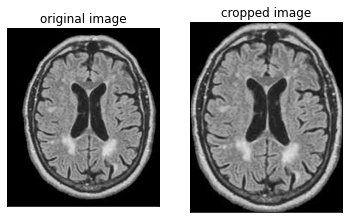

[[1.9134901e-04 9.9980873e-01]] [[0. 1.]]
0 )  predicted : No tumor | Original : No tumor | accurate : Yes.

----------score----------
accurate= 1 / 1  | accuracy= 100.0 %


In [298]:
test_img,test_target=prepare_image_target(path+"/no/22 no.jpg","no")
test_pred=model.predict_on_batch(test_img)
print(test_pred,test_target)
analysis_pred(test_pred,test_target,["tumor","No tumor"])